In [68]:
# Core libs
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# sklearn 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# IA + blockchain = profit
import tensorflow as tf
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Lambda, Dropout, BatchNormalization, Activation, Dense, LeakyReLU
from keras.layers.merging import Add, Concatenate
from keras.utils import plot_model, to_categorical

# Training

## Loading data

In [41]:
wierd = np.load('Clustering_W/clusters_labels.npy')
trainer_data = pd.read_pickle('../data/pak/log_data_pack_bigger')
trainer_data = trainer_data[np.invert(wierd)]
log_data = trainer_data.drop('Valorcomercial', axis=1)

In [42]:
#data_pca = PCA(n_components=3)
data_pca = PCA()

stadarizer = StandardScaler().fit(log_data)
sd_df = stadarizer.transform(log_data)

data_pca.fit(sd_df)
components = data_pca.transform(sd_df)


In [43]:
components.shape

(39733, 14)

## Custom metric

In [44]:
def mape_accuracy(y_true, y_pred):
    correct = tf.reduce_sum(tf.cast( tf.abs((y_true - y_pred)/y_pred) < 0.1, tf.int32), axis=1)
    total = y_true.shape[1]

    return (correct/total)*100

def mape_accuracy_log10(y_true, y_pred):
    correct = tf.reduce_sum(tf.cast(tf.abs(tf.divide(tf.subtract(tf.pow(tf.constant(10, dtype=tf.float32),y_true),tf.pow(tf.constant(10, dtype=tf.float32),y_pred)),tf.pow(tf.constant(10, dtype=tf.float32),y_true))) < 0.1, tf.int32), axis=1)
    #correct = tf.reduce_sum(tf.cast(tf.abs(tf.divide(tf.subtract((y_true + out_center)*out_scale ,(y_pred + out_center)*out_scale),y_true)) < 0.1, tf.int32), axis=1)
    total = y_true.shape[1]

    return (correct/total)*100

## Training data (Embedding)

In [45]:
X_emmbedder_train = components.copy()
#X_emmbedder_train = components.copy()*data_pca.explained_variance_ratio_[:3].transpose()
Y_emmbedder_train = trainer_data['Valorcomercial'].to_numpy()

## Training data (Inverse mapping)

In [46]:
X_inverse_train = np.concatenate((np.expand_dims(Y_emmbedder_train,axis=1), X_emmbedder_train), axis=1)
Y_inverse_train = np.power(10,Y_emmbedder_train)

## Create model

### Embedding

In [82]:
Xin = Input(shape=(14,),name='transformed_input')

X = Dense(14, activation=None, name='hidden_1_d')(Xin)

X = Dense(100, activation=None, name='hidden_2_d')(X)
X = LeakyReLU(0.5, name='hidden_2_a')(X)

X = Dense(100, activation=None, name='hidden_3_d')(X)
X = LeakyReLU(0.4, name='hidden_3_a')(X)

X = Dense(100, activation=None, name='hidden_4_d')(X)
X = LeakyReLU(0.5, name='hidden_4_a')(X)

X = Dense(100, activation=None, name='hidden_5_d')(X)
X = LeakyReLU(0.4, name='hidden_5_a')(X)

X = Dense(100, activation=None, name='hidden_6_d')(X)
X = LeakyReLU(0.5, name='hidden_6_a')(X)

X = Dropout(0.2)(X)

X = Dense(100, activation=None, name='hidden_7_d')(X)
X = LeakyReLU(0.4, name='hidden_7_a')(X)

X = Dense(100, activation=None, name='hidden_8_d')(X)
X = LeakyReLU(0.5, name='hidden_8_a')(X)

X = Dense(100, activation=None, name='hidden_9_d')(X)
X = LeakyReLU(0.4, name='hidden_9_a')(X)

X = Dense(100, activation=None, name='hidden_10_d')(X)
X = LeakyReLU(0.5, name='hidden_10_a')(X)

X = Dense(100, activation=None, name='hidden_11_d')(X)
X = LeakyReLU(0.4, name='hidden_11_a')(X)

X = Dense(50, activation=None, name='hidden_12_d')(X)
X = LeakyReLU(0.3, name='hidden_12_a')(X)

X = Dense(1, activation=None, name='predictor_d')(X)

Yout = LeakyReLU(0.2, name='predictor_a')(X)


S4D_jengi = Model(inputs = Xin, outputs = [Yout], name = 'S4DJengi')

epochs     = 100       # número de epocas
batch_size = 500        # tamaño del lote
alpha      = 0.0005    # razon de aprendizaje
decay      = 0.00001    # decaimiento de alpha

S4D_jengi.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                  loss      = 'mse',
                  metrics   = [mape_accuracy_log10])


#### Model summary (Embedding)

In [83]:
plot_model(S4D_jengi, to_file='S4D_jengi.png',show_shapes=True)
S4D_jengi.summary()

Model: "S4DJengi"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformed_input (InputLay  [(None, 14)]             0         
 er)                                                             
                                                                 
 hidden_1_d (Dense)          (None, 14)                210       
                                                                 
 hidden_2_d (Dense)          (None, 100)               1500      
                                                                 
 hidden_2_a (LeakyReLU)      (None, 100)               0         
                                                                 
 hidden_3_d (Dense)          (None, 100)               10100     
                                                                 
 hidden_3_a (LeakyReLU)      (None, 100)               0         
                                                          

#### Train model (Embedding)

In [88]:
epochs     = 1000       # número de epocas
batch_size = 200       # tamaño del lote
alpha      = 0.000008    # razon de aprendizaje
decay      = 0.00001    # decaimiento de alpha

S4D_jengi.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                  loss      = 'mae',
                  metrics   = [mape_accuracy_log10])


history = S4D_jengi.fit(x                = X_emmbedder_train,
                        y                = Y_emmbedder_train,
                        batch_size       = batch_size,
                        epochs           = epochs,
                        validation_split = 0.2,
                        verbose          = 1)

Epoch 1/1000
159/159 [==============================] - 2s 6ms/step - loss: 0.1344 - mape_accuracy_log10: 25.8195 - val_loss: 0.1431 - val_mape_accuracy_log10: 23.5183
Epoch 2/1000
159/159 [==============================] - 1s 4ms/step - loss: 0.1342 - mape_accuracy_log10: 25.8195 - val_loss: 0.1446 - val_mape_accuracy_log10: 22.9772
Epoch 3/1000
159/159 [==============================] - 1s 4ms/step - loss: 0.1344 - mape_accuracy_log10: 26.0649 - val_loss: 0.1447 - val_mape_accuracy_log10: 22.6123
Epoch 4/1000
159/159 [==============================] - 1s 4ms/step - loss: 0.1340 - mape_accuracy_log10: 25.8290 - val_loss: 0.1452 - val_mape_accuracy_log10: 22.6123
Epoch 5/1000
159/159 [==============================] - 1s 4ms/step - loss: 0.1344 - mape_accuracy_log10: 26.0335 - val_loss: 0.1446 - val_mape_accuracy_log10: 22.4236
Epoch 6/1000
159/159 [==============================] - 1s 4ms/step - loss: 0.1345 - mape_accuracy_log10: 26.0272 - val_loss: 0.1458 - val_mape_accuracy_log10: 

KeyboardInterrupt: 

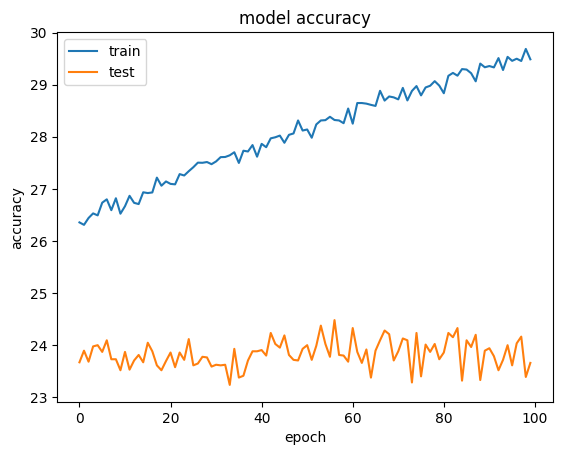

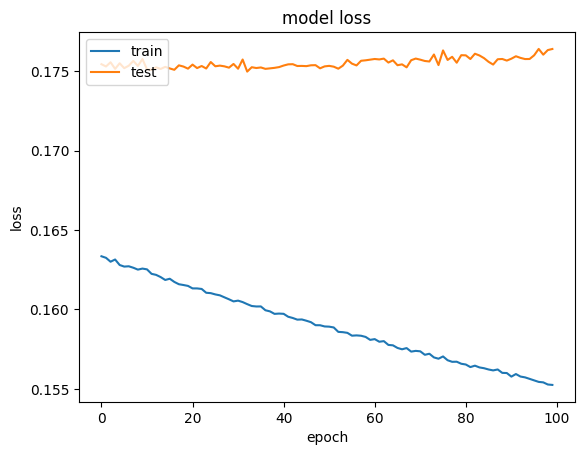

In [37]:
plt.plot(history.history['mape_accuracy_log10'])
plt.plot(history.history['val_mape_accuracy_log10'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Inverse mapping

In [72]:
Xin = Input(shape=(7,),name='transformed_input')
X = Dense(15, activation='relu', name='hidden_1')(Xin)
X = Dense(100, activation=tf.keras.activations.exponential, name='hidden_2')(X)
X = Dense(100, activation='relu', name='hidden_3')(X)
X = Dense(50, activation='relu', name='hidden_4')(X)
X = Dense(25, activation='relu', name='hidden_5')(X)
X = Dense(10, activation='relu', name='hidden_6')(X)
X = Dense(5, activation='relu', name='hidden_7')(X)
X = Dense(5, activation='relu', name='hidden_8')(X)
Yout = Dense(1, activation=None, name='predictor')(X)

S4D_gumbo = Model(inputs = Xin, outputs = [Yout], name = 'S4DGumbo')

epochs     = 20       # número de epocas
batch_size = 20        # tamaño del lote
alpha      = 0.005    # razon de aprendizaje
decay      = 0.001    # decaimiento de alpha

S4D_gumbo.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                  loss      = tf.keras.losses.mean_absolute_percentage_error,
                  metrics   = [mape_accuracy])


#### Model summary (Embedding)

In [73]:
plot_model(S4D_gumbo, to_file='S4D_gumbo.png',show_shapes=True)
S4D_gumbo.summary()

Model: "S4DGumbo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformed_input (InputLay  [(None, 7)]              0         
 er)                                                             
                                                                 
 hidden_1 (Dense)            (None, 15)                120       
                                                                 
 hidden_2 (Dense)            (None, 100)               1600      
                                                                 
 hidden_3 (Dense)            (None, 100)               10100     
                                                                 
 hidden_4 (Dense)            (None, 50)                5050      
                                                                 
 hidden_5 (Dense)            (None, 25)                1275      
                                                          

#### Train model (Embedding)

In [77]:
epochs     = 10       # número de epocas
batch_size = 100        # tamaño del lote
alpha      = 0.0001    # razon de aprendizaje
decay      = 0.00001    # decaimiento de alpha

S4D_gumbo.compile(optimizer = optimizers.Adam(learning_rate=alpha, decay=decay),
                  loss      = tf.keras.losses.mean_absolute_percentage_error,
                  metrics   = [mape_accuracy])

history = S4D_gumbo.fit(x                = X_inverse_train,
                        y                = Y_inverse_train,
                        batch_size       = batch_size,
                        epochs           = epochs,
                        validation_split = 0.2,
                        verbose          = 1)

Epoch 1/10
318/318 [==============================] - 2s 5ms/step - loss: 0.5697 - mape_accuracy: 99.6036 - val_loss: 0.5287 - val_mape_accuracy: 99.6099
Epoch 2/10
318/318 [==============================] - 2s 5ms/step - loss: 0.5315 - mape_accuracy: 99.6225 - val_loss: 0.5218 - val_mape_accuracy: 99.6351
Epoch 3/10
318/318 [==============================] - 2s 5ms/step - loss: 0.5082 - mape_accuracy: 99.6382 - val_loss: 0.4924 - val_mape_accuracy: 99.6602
Epoch 4/10
318/318 [==============================] - 2s 5ms/step - loss: 0.4979 - mape_accuracy: 99.6476 - val_loss: 0.5166 - val_mape_accuracy: 99.6602
Epoch 5/10
318/318 [==============================] - 2s 5ms/step - loss: 0.4808 - mape_accuracy: 99.6697 - val_loss: 0.4725 - val_mape_accuracy: 99.6602
Epoch 6/10
318/318 [==============================] - 2s 5ms/step - loss: 0.4641 - mape_accuracy: 99.6728 - val_loss: 0.4589 - val_mape_accuracy: 99.6854
Epoch 7/10
318/318 [==============================] - 2s 5ms/step - loss: 0.

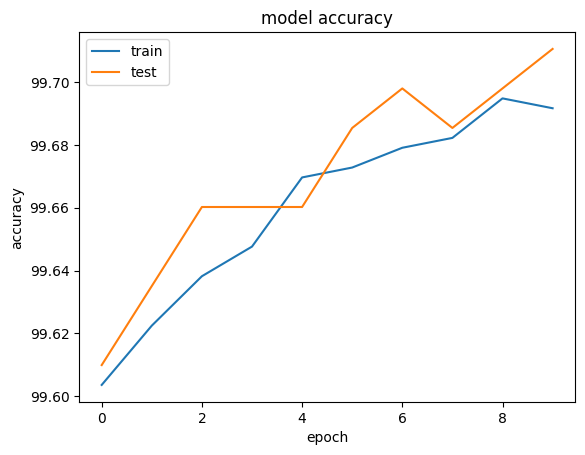

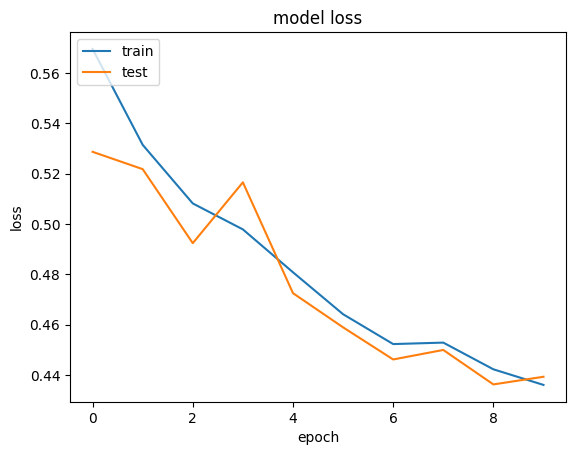

In [78]:
plt.plot(history.history['mape_accuracy'])
plt.plot(history.history['val_mape_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Full model

In [79]:
from keras.layers import Concatenate, Flatten

Xin = Input(shape=(6,),name='transformed_input')

# Jengi
Y_jengi = S4D_jengi(Xin)

# Bridge
X = Concatenate(axis=1)([Y_jengi,Xin])

# Gumbo
Yout = S4D_gumbo(X)

S4D_Her0 = Model(inputs = Xin, outputs = Yout, name = 'S4DHer0')

epochs     = 800       # número de epocas
batch_size = 500        # tamaño del lote
alpha      = 0.0005    # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

S4D_Her0.compile(optimizer = optimizers.Adadelta(),
                 loss      = tf.keras.losses.mean_absolute_percentage_error,
                 metrics   = [mape_accuracy])


#### Model summary (Embedding)

In [80]:
plot_model(S4D_Her0, to_file='IneedAHer0.png',show_shapes=True)
S4D_Her0.summary()

Model: "S4DHer0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 transformed_input (InputLayer)  [(None, 6)]         0           []                               
                                                                                                  
 S4DJengi (Functional)          (None, 1)            405         ['transformed_input[0][0]']      
                                                                                                  
 concatenate_1 (Concatenate)    (None, 7)            0           ['S4DJengi[0][0]',               
                                                                  'transformed_input[0][0]']      
                                                                                                  
 S4DGumbo (Functional)          (None, 1)            18496       ['concatenate_1[0][0]']    

#### Train model (Embedding)

In [84]:
epochs     = 1000       # número de epocas
batch_size = 100        # tamaño del lote
alpha      = 0.0001    # razon de aprendizaje
decay      = 0.00001    # decaimiento de alpha

S4D_Her0.compile(optimizer = optimizers.Adam(learning_rate=alpha),
                  loss      = tf.keras.losses.mean_absolute_percentage_error,
                  metrics   = [mape_accuracy])


history = S4D_Her0.fit(x                 = X_emmbedder_train,
                        y                = Y_inverse_train,
                        batch_size       = batch_size,
                        epochs           = epochs,
                        validation_split = 0.2,
                        verbose          = 1)

Epoch 1/1000
318/318 [==============================] - 3s 6ms/step - loss: 33.2597 - mape_accuracy: 18.8511 - val_loss: 33.3118 - val_mape_accuracy: 17.8810
Epoch 2/1000
318/318 [==============================] - 2s 6ms/step - loss: 33.2497 - mape_accuracy: 18.6214 - val_loss: 33.3154 - val_mape_accuracy: 17.9187
Epoch 3/1000
318/318 [==============================] - 2s 6ms/step - loss: 33.2833 - mape_accuracy: 18.7472 - val_loss: 33.3322 - val_mape_accuracy: 18.4850
Epoch 4/1000
318/318 [==============================] - 2s 6ms/step - loss: 33.2137 - mape_accuracy: 18.7126 - val_loss: 33.4359 - val_mape_accuracy: 18.3214
Epoch 5/1000
318/318 [==============================] - 2s 6ms/step - loss: 33.2939 - mape_accuracy: 18.9014 - val_loss: 33.2864 - val_mape_accuracy: 18.2962
Epoch 6/1000
318/318 [==============================] - 2s 6ms/step - loss: 33.2403 - mape_accuracy: 18.7315 - val_loss: 33.4888 - val_mape_accuracy: 19.0890
Epoch 7/1000
318/318 [==============================

In [74]:
S4D_Her0.save('S4D_Her0/S4D_Her02.h5')
#S4D_jengi.save('S4D_jengi/S4D_jengi.h5')
#S4D_gumbo.save('S4D_gumbo/S4D_gumbo.h5')

ValueError: Unable to create dataset (name already exists)

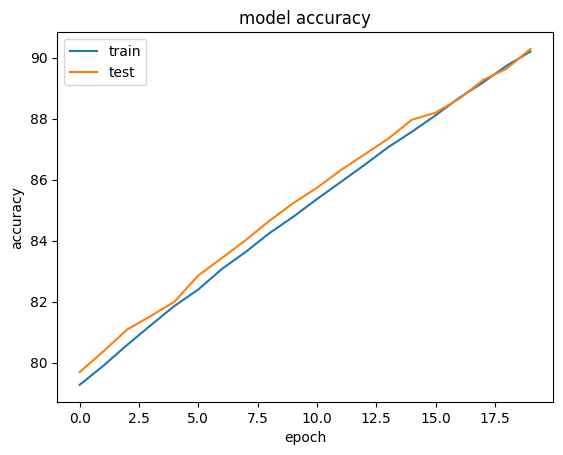

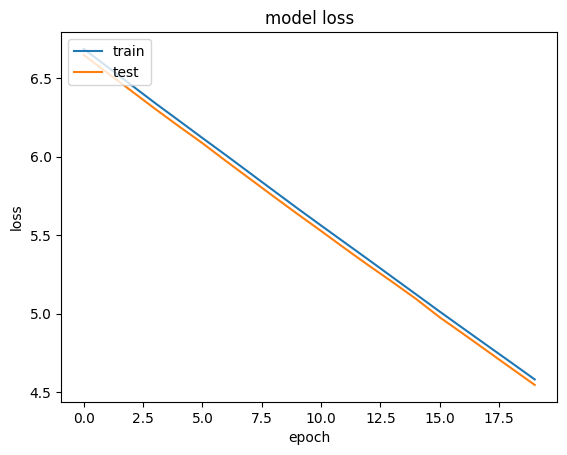

In [ ]:
plt.plot(history.history['mape_accuracy'])
plt.plot(history.history['val_mape_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Validation

In [ ]:
def pre_proccess_data (data):
    return data_pca.transform(stadarizer.transform(data))

In [ ]:
def import_data_train(path):
    features = ['Número de estacionamiento',
                'Depósitos',
                'Edad',
                'Elevador',
                'Área Terreno',
                'Área Construcción',
                'Valor comercial (USD)']

    eps = 0.0000001

    raw_data = pd.read_excel(path, header = [0], index_col=None).drop(['ranva'], axis=1).fillna(0.0)

    data = raw_data[features].copy()
    data = data.applymap(lambda x : float(x.replace(',','')) if isinstance(x,str) else x)
    log_data = data.applymap(lambda x : np.log10(x + eps))

    return log_data

In [ ]:
ord20p = import_data_train('validate/dataset/path')

features_data = ord20p.drop('Valor comercial (USD)')

X_test = pre_proccess_data(features_data)
Y_test = ord20p['Valor comercial (USD)']

score = S4D_gumbo.evaluate(X_test, Y_test, verbose = 1)

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])